### Binary Classification with Python

In [1]:
# Activation functions & derivatives
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def dSigmoid(Z):
    return Sigmoid(Z) * (1-Sigmoid(Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dRelu2(dZ, Z):    
    dZ[Z<=0] = 0    
    return dZ

class NeuralNetwork:
    def __init__(self, x, y):
        self.X = x
        self.Y = y
        self.Yh = np.zeros((1, self.Y.shape[1])) 
        self.layers = [self.X.shape[0], 100, 1]
        self.params = {}
        self.grads = {}
        self.m = {}
        self.v = {}
        self.cache = ()
        self.loss = []
        self.lr = 0.003
        self.sam = self.Y.shape[1]
        self.threshold = 0.5
        
    def he_initialize(self):    
        np.random.seed(1)
        L = len(self.layers) 
        # He weight initializations & zero initialization for biases
        for l in range(1, L):
            self.params[f'W{str(l)}'] = np.random.randn(self.layers[l], self.layers[l-1]) / np.sqrt(self.layers[l-1])
            self.params[f'b{str(l)}'] = np.zeros((self.layers[l], 1))
        return 
    
    def initialize_adam_optimizer(self):
        L = len(self.layers)
        for l in range(1, L):
            self.m[f'dW{str(l)}'] = np.zeros(self.params[f'W{str(l)}'].shape)
            self.m[f'db{str(l)}'] = np.zeros(self.params[f'b{str(l)}'].shape)
            self.v[f'dW{str(l)}'] = np.zeros(self.params[f'W{str(l)}'].shape)
            self.v[f'db{str(l)}'] = np.zeros(self.params[f'b{str(l)}'].shape)
        return
    
    def forward_prop(self, lambd):
        Z1 = np.dot(self.params['W1'], self.X) + self.params['b1'] 
        A1 = Relu(Z1)
        Z2 = np.dot(self.params['W2'], A1) + self.params['b2'] 
        A2 = Sigmoid(Z2) 
        self.cache = (Z1, A1, Z2, A2)
        self.Yh = A2
        loss = self.cost(A2, lambd)
        return self.Yh, loss

    def backward_prop_with_regularization(self, lambd):
        (Z1, A1, Z2, A2) = self.cache
        # Compute derivative of loss with respect to predicted class label
        self.grads['dYh'] = -(np.divide(self.Y, self.Yh) - np.divide(1 - self.Y, 1 - self.Yh))
        # Compute derivative of loss with respect to W2
        self.grads['dZ2'] = self.grads['dYh'] * dSigmoid(Z2)    
        self.grads['dA2'] = np.dot(self.params['W2'].T, self.grads['dZ2'])
        self.grads['dW2'] = 1./A1.shape[1] * np.dot(self.grads['dZ2'], A1.T) + lambd/A1.shape[1] * self.params['W2']
        self.grads['db2'] = 1./A1.shape[1] * np.dot(self.grads['dZ2'], np.ones([self.grads['dZ2'].shape[1], 1])) 
        # Compute derivative of loss with respect to W1
        self.grads['dZ1'] = self.grads['dA2'] * dRelu(Z1)        
        self.grads['dA1'] = np.dot(self.params['W1'].T, self.grads['dZ1'])
        self.grads['dW1'] = 1./self.X.shape[1] * np.dot(self.grads['dZ1'], self.X.T) + lambd/self.X.shape[1] * self.params['W1']
        self.grads['db1'] = 1./self.X.shape[1] * np.dot(self.grads['dZ1'], np.ones([self.grads['dZ1'].shape[1], 1]))  
        return
    
    def update_adam_optimizer(self, beta1, beta2, t, epsilon):
        L = len(self.layers) 
        m_hat = {}
        v_hat = {}
        for l in range(1, L):
            # First moment using beta1 & gradients
            self.m[f'dW{str(l)}'] = beta1 * self.m[f'dW{str(l)}'] + (1 - beta1) * self.grads[f'dW{str(l)}']
            self.m[f'db{str(l)}'] = beta1 * self.m[f'db{str(l)}'] + (1 - beta1) * self.grads[f'db{str(l)}']
            # Bias correction for first moment
            m_hat[f'dW{str(l)}'] = self.m[f'dW{str(l)}']/(1 - beta1**t)
            m_hat[f'db{str(l)}'] = self.m[f'db{str(l)}']/(1 - beta1**t)
            # Second moment using beta2 & squared gradients 
            self.v[f'dW{str(l)}'] = beta2 * self.v[f'dW{str(l)}'] + (1 - beta2) * self.grads[f'dW{str(l)}']**2
            self.v[f'db{str(l)}'] = beta2 * self.v[f'db{str(l)}'] + (1 - beta2) * self.grads[f'db{str(l)}']**2
            # Bias correction for second moment
            v_hat[f'dW{str(l)}'] = self.v[f'dW{str(l)}']/(1 - beta2**t)
            v_hat[f'db{str(l)}'] = self.v[f'db{str(l)}']/(1 - beta2**t)

            # Update weights & bias
            self.params[f'W{str(l)}'] = self.params[f'W{str(l)}'] - self.lr * m_hat[f'dW{str(l)}'] / (np.sqrt(v_hat[f'dW{str(l)}']) + epsilon)
            self.params[f'b{str(l)}'] = self.params[f'b{str(l)}'] - self.lr * m_hat[f'db{str(l)}'] / (np.sqrt(v_hat[f'db{str(l)}']) + epsilon)
        return
        
    def cost(self, Yh, lambd):
        # Cross-entropy loss
        cost = (1./self.sam) * (-np.dot(self.Y, np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))   
        # Add regularization
        L2_reg = (1./self.sam) * (lambd/2) * (np.sum(np.square(self.params['W1'])) + np.sum(np.square(self.params['W2'])))
        cost += L2_reg
        cost = np.squeeze(cost)
        return cost

    def pred(self, x, y):  
        self.X = x
        self.Y = y
        comp = np.zeros((1, x.shape[1]))
        pred, loss = self.forward_prop(lambd=1e-3)    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        return comp
    
    def adam(self,X, Y, iter = 3000, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        np.random.seed(1)  
        self.he_initialize()
        self.initialize_adam_optimizer()
        t = 0
        for i in range(0, iter): 
            Yh, loss = self.forward_prop(lambd=1e-3)
            self.backward_prop_with_regularization(lambd=1e-3)
            t += 1
            self.update_adam_optimizer(beta1, beta2, t, epsilon)
            if i % 500 == 0:
                print ("Cost after epoch %i: %f" %(i, loss))
                self.loss.append(loss)
               
        plt.plot(self.loss)
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.title("Lr =" + str(self.lr))
        plt.show()
        return 

### Data Pre-processing


In [3]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load training dataset
train = np.loadtxt('train.dat', dtype='str', unpack=True)
X_train = np.array(train[1])
y_train = np.array(list((map(int, train[0]))))

# Load test dataset
X_test = np.loadtxt('test.dat', dtype='str', unpack=True)
y_test = np.loadtxt('format.dat', dtype='int', unpack=True)

# k-mers function for feature extraction
def kmers(sequence, k):
    data = {}
    size = len(sequence)
    for i in range(size - k + 1):
        kmer = sequence[i:i+k]
        # Replace X as V amino acid 
        if 'X' in kmer:
            kmer = kmer.replace('X', 'V')
        data[kmer] = data.get(kmer, 0) + 1
    return data

# List of occurences of each 2-petitde sequence feature for all peptides
train_features = np.array([kmers(peptide, 3) for peptide in X_train])
test_features = np.array([kmers(peptide, 3) for peptide in X_test])

# Extract features  
def feature_extraction(features):
    data_dict = {}
    for f in features:
        for k in f:
            data_dict[k] = data_dict.get(k, 0) + 1
    return data_dict

train_data = feature_extraction(train_features)
test_data = feature_extraction(test_features)

# Extract all features in both training & test data        
columns = np.array(list(set(train_data.keys()) | set(test_data.keys())))
# Create empty feature matrices
X_train = np.zeros((train_features.shape[0], columns.shape[0]), dtype=np.int8)
X_test = np.zeros((test_features.shape[0], columns.shape[0]), dtype=np.int8)

# Fill in feature matrices
def process_features(features, matrix):
    for i, f in enumerate(features):
        for j, key in enumerate(columns):
            if key in f:
                matrix[i][j] = f[key]

process_features(train_features, X_train)
print(train_features, X_train)
process_features(test_features, X_test)

# Oversample positive class (1) to balance dataset
df = pd.DataFrame(X_train, columns=columns)
df['Class']=y_train
pos_class = df[df['Class']==1]
neg_class = df[df['Class']==-1]
oversample_n = len(df) - 2*len(pos_class)
df_positive_oversample = pos_class.sample(n=oversample_n, replace=True, random_state=1)
df_oversampled = pd.concat([df, df_positive_oversample])
X_train, y_train = df_oversampled.iloc[:,:-1].to_numpy(), df_oversampled['Class'].to_numpy()

# Scale features to have feature values between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Encode -1 as 0 class labels
def encode_labels(y):
    y[y == -1] = 0
    return y

# Decode 0 to -1 class labels
def decode_labels(y):
    y[y == 0] = -1
    return y

# Reshape training & test datasets and encode class labels
X_train, X_test = X_train.T, X_test.T
y_train, y_test = encode_labels(y_train.reshape((1, y_train.shape[0]))), encode_labels(y_test.reshape((1, y_test.shape[0])))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


[{'DVE': 1, 'VEL': 1, 'ELD': 1, 'LDL': 1, 'DLV': 1, 'LVE': 1, 'VEI': 1, 'EIS': 1, 'ISP': 1, 'SPN': 1, 'PNA': 1, 'NAL': 1, 'ALP': 1}
 {'KAD': 1, 'ADE': 1, 'DEE': 1, 'EEL': 1, 'ELF': 1, 'LFN': 1, 'FNK': 1, 'NKL': 1, 'KLF': 1, 'LFF': 1, 'FFG': 1, 'FGT': 1}
 {'FLV': 1, 'LVA': 1, 'VAL': 1, 'ALH': 1, 'LHL': 1, 'HLG': 1, 'LGT': 1, 'GTA': 1, 'TAF': 1, 'AFA': 1, 'FAL': 1, 'ALL': 1, 'LLW': 1, 'LWY': 1, 'WYF': 1, 'YFR': 1, 'FRK': 1, 'RKR': 1, 'KRW': 1, 'RWC': 1, 'WCA': 1, 'CAL': 1, 'ALV': 1, 'LVR': 1, 'VRG': 1, 'RGF': 1, 'GFF': 1, 'FFA': 1, 'FAS': 1, 'ASF': 1, 'SFG': 1, 'FGG': 1, 'GGR': 1, 'GRR': 1, 'RRN': 1, 'RND': 1, 'NDD': 1, 'DDA': 1, 'DAH': 1, 'AHM': 1, 'HMM': 1}
 ...
 {'KWK': 1, 'WKI': 1, 'KIR': 1, 'IRV': 1, 'RVR': 1, 'VRL': 1, 'RLS': 1, 'LSA': 1}
 {'TLN': 1, 'LNT': 1, 'NTV': 1, 'TVV': 1, 'VVG': 1, 'VGS': 1, 'GSI': 1, 'SIS': 1, 'ISG': 1, 'SGA': 1, 'GAV': 1, 'AVP': 1}
 {'HFR': 1, 'FRS': 1, 'RSQ': 1}]
[{'DVE': 1, 'VEL': 1, 'ELD': 1, 'LDL': 1, 'DLV': 1, 'LVE': 1, 'VEI': 1, 'EIS': 1, 'ISP': 1, 

#### Train neural network

Cost after epoch 0: 0.692178
Cost after epoch 500: 0.010946
Cost after epoch 1000: 0.002838
Cost after epoch 1500: 0.001342
Cost after epoch 2000: 0.000836
Cost after epoch 2500: 0.000611
Cost after epoch 3000: 0.000491
Cost after epoch 3500: 0.000418
Cost after epoch 4000: 0.000369
Cost after epoch 4500: 0.000332
Cost after epoch 5000: 0.000302
Cost after epoch 5500: 0.000276
Cost after epoch 6000: 0.000252
Cost after epoch 6500: 0.000229
Cost after epoch 7000: 0.000208
Cost after epoch 7500: 0.000187
Cost after epoch 8000: 0.000168
Cost after epoch 8500: 0.000149
Cost after epoch 9000: 0.000132
Cost after epoch 9500: 0.000116


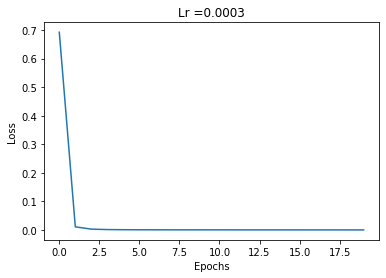

In [3]:
nn = NeuralNetwork(X_train, y_train)
nn.lr = 3e-4
nn.adam(X_train, y_train, iter = 10000)

#### MCC Scoring Function

In [4]:
# Predict
pred_train = nn.pred(X_train, y_train).astype(int)
pred_test = nn.pred(X_test, y_test).astype(int)
# Decode class labels
y_train, y_test, pred_test = decode_labels(y_train), decode_labels(y_test), decode_labels(pred_test)


Acc: 0.9999999999999999
Acc: 0.5076530612244898


#### Save test data predictions to text file

In [5]:
def output_data(data):
    data = [d for d in data.flatten()]
    with open('test.txt', 'w') as txtfile:
        for d in data:
            txtfile.write(str(d) + '\n')
            
output_data(pred_test)

### Binary Classification with TensorFlow

2022-01-24 16:29:47.512075: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-24 16:29:47.512611: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


(2848, 7090) (2848, 1)
Train on 2278 samples, validate on 570 samples
Epoch 1/100
2278/2278 [==============================] - 2s 740us/sample - loss: 0.7491 - accuracy: 0.8907 - val_loss: 0.4311 - val_accuracy: 0.9368
Epoch 2/100
2278/2278 [==============================] - 0s 214us/sample - loss: 0.6554 - accuracy: 0.9877 - val_loss: 0.3934 - val_accuracy: 0.9895
Epoch 3/100
2278/2278 [==============================] - 0s 207us/sample - loss: 0.6272 - accuracy: 0.9969 - val_loss: 0.3768 - val_accuracy: 0.9947
Epoch 4/100
2278/2278 [==============================] - 0s 210us/sample - loss: 0.6128 - accuracy: 0.9982 - val_loss: 0.3678 - val_accuracy: 0.9947
Epoch 5/100
2278/2278 [==============================] - 1s 221us/sample - loss: 0.6031 - accuracy: 0.9978 - val_loss: 0.3628 - val_accuracy: 0.9947
Epoch 6/100
2278/2278 [==============================] - 0s 213us/sample - loss: 0.5971 - accuracy: 0.9982 - val_loss: 0.3579 - val_accuracy: 0.9947
Epoch 7/100
2278/2278 [=============

Training loss: 0.5368081810099355, Training accuracy: 1.0


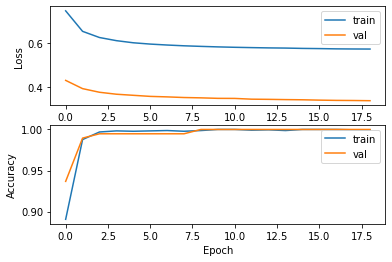

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

tf.random.set_seed(10)
n_features = X_train.shape[0]

# Build model layers
model = Sequential([
    Dense(30, input_shape=(n_features,), 
          activation='relu', 
          kernel_initializer='he_uniform',
        kernel_regularizer=l2(1e-3)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Early stopping callback to stop training when there is no improvement in validation loss for 10 epochs
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=10,
                   restore_best_weights=True)

# Update model fit
history = model.fit(X_train.T, y_train.T, callbacks=[es], epochs=100, validation_split=0.2)

# Evaluate model's performance on training data
train_score = model.evaluate(X_train.T, y_train.T)
print(f'Training loss: {train_score[0]}, Training accuracy: {train_score[1]}')

fig, axs = plt.subplots(2, 1)
# Plot loss
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set(ylabel='Loss')
# Plot accuracy
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set(ylabel='Accuracy')
plt.xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.show()
